In [1]:
# Import statements
import numpy as np
import pandas as pd

from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split

# from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample

# Models
from sklearn.linear_model import SGDClassifier # SGD model

In [2]:
# Reading into data frame from file
data_frame = pd.read_csv('./creditcard.csv')

In [3]:
# Load models from files if desired
from pickle import load
load_models = False

if load_models:
    with open("SGDClassifier_model.pkl", "rb") as file:
        clf = load(file)
    with open("SGDClassifier_model_resampled.pkl", "rb") as file:
        clf_resampled = load(file)
else:
    clf, clf_resampled = None, None

In [4]:
# Data to fit and targets
feature_set = ["Time", "V1", "V2", "V3", "V4", "V5", "V6", "V7", "V8", "V9", "V10", "V11", "V12", "V13", "V14", "V15", "V16", "V17", "V18", "V19", "V20", "V21", "V22", "V23", "V24", "V25", "V26", "V27", "V28", "Amount"]\
# sub_set = ["Time", "V1", "V2", "V3", "V4", "Amount"]
target_set = ["Class"]

X = data_frame[feature_set]
y = data_frame[target_set]

# y.head()
# print(y)

In [5]:
# Splits data into 80-20 train-test
# Prevents data leakage (where training and test sets influence each other in scaling)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)

# print((y_train["Class"] == 1).sum())
# print((y_test["Class"] == 1).sum())

In [6]:
# Balancing data set with resampling
from nb_functions import resample_fraud_dataset

# Same number fraud and not-fraud cases
X_train_resampled, y_train_resampled = resample_fraud_dataset(X_train, y_train)
print((y_train_resampled["Class"] == 0).sum())
print((y_train_resampled["Class"] == 1).sum())

227451
227451


In [7]:
# Initialize model(s)
if clf == None:
    clf = SGDClassifier(random_state=1) # Apparently prefers standard scaling
if clf_resampled == None:
    clf_resampled = SGDClassifier(random_state=1)

# Collect predictions from non-resample trained model
if not load_models:
    clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

# Collect predictions from resample trained model
if not load_models:
    clf_resampled.fit(X_train_resampled, y_train_resampled)
y_resampled_pred = clf_resampled.predict(X_test)

In [14]:
from sklearn.model_selection import GridSearchCV

parameters = {
    'alpha': [0.0001, 0.001, 0.01],
    'penalty': ['l2', 'l1', 'elasticnet'],
    'loss': ['hinge', 'log_loss', 'squared_hinge'],
    'learning_rate': ['optimal', 'constant', 'adaptive'],
    'max_iter': [1000, 2000, 5000]
}

kf = StratifiedKFold(n_splits=3)
# grid_search = GridSearchCV(clf, parameters, cv=kf, scoring='f1')
# grid_search.fit(X_train, y_train.values.ravel())

grid_search = GridSearchCV(clf_resampled, parameters, cv=kf, scoring='f1')
grid_search.fit(X_train_resampled, y_train_resampled.values.ravel())

print("Cross-Validation Score of Best Model Found: ", grid_search.best_score_)
print("Best Parameters Found: ", grid_search.best_params_)

/home/quetzl/.pyenv/versions/ml-project-2025/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:516: FitFailedWarning: 
567 fits failed out of a total of 729.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
243 fits failed with the following error:
Traceback (most recent call last):
  File "/home/quetzl/.pyenv/versions/ml-project-2025/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/quetzl/.pyenv/versions/ml-project-2025/lib/python3.12/site-packages/sklearn/base.py", line 1358, in wrapper
    estimator._validate_params()
  File "/home/quetzl/.pyenv/versions/ml-project-2025/lib/python3.12/site-packages/sklearn/

Cross-Validation Score of Best Model Found:  0.9088693903082848
Best Parameters Found:  {'alpha': 0.001, 'learning_rate': 'optimal', 'loss': 'squared_hinge', 'max_iter': 1000, 'penalty': 'l1'}


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.00      0.00      0.00        98

    accuracy                           1.00     56962
   macro avg       0.50      0.50      0.50     56962
weighted avg       1.00      1.00      1.00     56962

              precision    recall  f1-score   support

           0       1.00      0.99      1.00     56864
           1       0.16      0.63      0.25        98

    accuracy                           0.99     56962
   macro avg       0.58      0.81      0.62     56962
weighted avg       1.00      0.99      1.00     56962



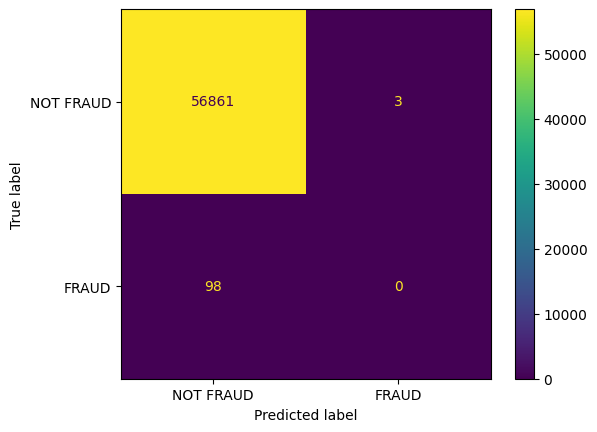

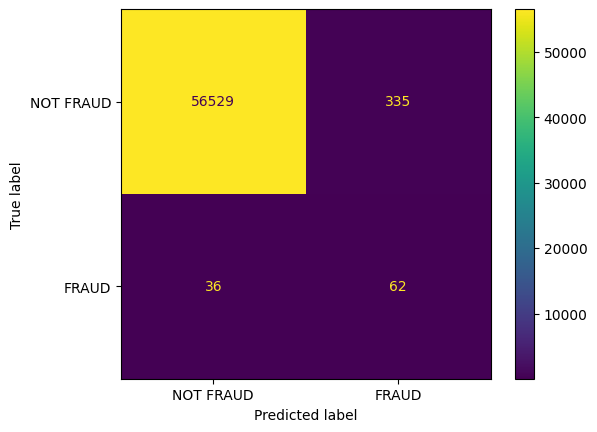

In [8]:
from sklearn import metrics
# Metrics for non-resampled model
print(metrics.classification_report(y_test, y_pred))
cm = metrics.confusion_matrix(y_test, y_pred)
metrics.ConfusionMatrixDisplay(cm, display_labels=["NOT FRAUD", "FRAUD"]).plot()

# Metrics for resampled model
print(metrics.classification_report(y_test, y_resampled_pred))
cm_resampled = metrics.confusion_matrix(y_test, y_resampled_pred)
metrics.ConfusionMatrixDisplay(cm_resampled, display_labels=["NOT FRAUD", "FRAUD"]).plot()

In [10]:
# Cross validation score for not resampled
kf = StratifiedKFold(n_splits=5)
cv_scores = cross_val_score(clf, X_train, y_train.values.ravel(), cv=kf, scoring="f1")
print("Cross validation scores:", cv_scores)
print(f"Mean Validation Score: {np.mean(cv_scores)}")

# Cross validation score for resampled
cv_scores_resampled = cross_val_score(clf, X_train_resampled, y_train_resampled.values.ravel(), cv=kf, scoring="f1")
print("Cross Resampled validation scores:", cv_scores_resampled)
print(f"Mean Resampled Validation Score: {np.mean(cv_scores_resampled)}")

Cross validation scores: [0. 0. 0. 0. 0.]
Mean Validation Score: 0.0
Cross Resampled validation scores: [0.83381614 0.66988175 0.91846477 0.91097096 0.54438794]
Mean Resampled Validation Score: 0.7755043122294765


In [ ]:
# Display AUPRC for non-resampled
import matplotlib.pyplot as plt

precision, recall, thresholds = metrics.precision_recall_curve(y_test, y_pred)
plt.figure(figsize=(8,6))
display = metrics.PrecisionRecallDisplay(precision=precision, recall=recall)
display.plot()

plt.title("Precision-Recall Curve")
plt.show()

In [ ]:
# Display AUPRC for resampled
import matplotlib.pyplot as plt

precision, recall, thresholds = metrics.precision_recall_curve(y_test, y_resampled_pred)
plt.figure(figsize=(8,6))
display = metrics.PrecisionRecallDisplay(precision=precision, recall=recall)
display.plot()

plt.title("Resampled Precision-Recall Curve")
plt.show()

In [ ]:
from pickle import dump
save_models = False

if save_models:
    with open ("SGDClassifier_model_resampled.pkl", "wb") as file:
        dump(clf_resampled, file)
    with open ("SGD_Classifier_model.pkl", "wb") as file:
        dump(clf, file)